In [1]:
import numpy as np
np.random.seed(1019)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import xgboost

import sklearn
from sklearn.model_selection import train_test_split 

import sys, os, gc, types
import time
from subprocess import check_output

In [2]:
sys.path.append('./utils')

from training import cv, train
from plotting import plot_importance
from data import Data

In [3]:
root_paths = [
    "/data/kaggle-instacart",
    "/Users/jiayou/Dropbox/珺珺的程序/Kaggle/Instacart",
    "/Users/jiayou/Dropbox/Documents/珺珺的程序/Kaggle/Instacart"
]
root = None
for p in root_paths:
    if os.path.exists(p):
        root = p
        break

In [47]:
name = 'v10-t0'


down_sample = 999
folds=5
aug=False

boosting_rounds = 100
stopping_rounds = 10
xgb_params = {
    "booster"          : "gbtree",
    "tree_method"      : "hist",
    "learning_rate"    : 0.1,
    "max_depth"        : 2,
    "min_child_weight" : 10, # hessian weight
    "subsample"        : 0.7,
    "colsample_bytree" : 0.9,
        
    "objective"        : "reg:logistic",
    "eval_metric"      : "logloss",
    
    "min_split_loss"   : 0.7, # ?
    "reg_alpha"        : 2e-05,
    "reg_lambda"       : 10
#     "grow_policy"      : ["lossguide"]
}


----

# xgb top model training and prediction

In [51]:
train_df = Data.train(down_sample=down_sample, aug=aug)

test = Data.test(down_sample=down_sample)

In [52]:
bnames = ['v10-b{}'.format(i) for i in range(4)]

# Load data with reorder prob - 6 prediction csv files
# merge reorder prob to train_df
for bname in bnames:
# bname = 'v10-b0'
    pred=[]
    for i in range(folds):
        pred.append(pd.read_csv(os.path.join(root, 'stacking', 'val_prediction.{}.cv{}.csv'.format(bname, i))))
        pred[i].rename(columns={'reorder_prob':bname}, inplace=True)

    pred_df = pd.concat([pred[i] for i in range(folds)])
    train_df = train_df.merge(pred_df, on=['order_id','product_id'], how='left')

    # merge reorder prob to test
    pred_t_df = pd.read_csv(os.path.join(root, 'stacking', 'test_prediction.{}.csv'.format(bname)))
    pred_t_df.rename(columns={'reordered':bname}, inplace=True)
    test = test.merge(pred_t_df, on=['order_id','product_id'], how='left')

876 37
220 37
Round 0 update starts...
Round 0 update: 0.00s
Round 0 eval starts...
Round 0 eval: 0.00s
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 10 rounds.
[0]	train-logloss:0.634388	val-logloss:0.632855
Round 1 update starts...
Round 1 update: 0.00s
Round 1 eval starts...
Round 1 eval: 0.00s
[1]	train-logloss:0.585432	val-logloss:0.58339
Round 2 update starts...
Round 2 update: 0.00s
Round 2 eval starts...
Round 2 eval: 0.00s
[2]	train-logloss:0.544792	val-logloss:0.541327
Round 3 update starts...
Round 3 update: 0.00s
Round 3 eval starts...
Round 3 eval: 0.00s
[3]	train-logloss:0.51133	val-logloss:0.506922
Round 4 update starts...
Round 4 update: 0.00s
Round 4 eval starts...
Round 4 eval: 0.00s
[4]	train-logloss:0.482675	val-logloss:0.477279
Round 5 update starts...
Round 5 update: 0.00s
Round 5 eval starts...
Round 5 eval: 0.00s
[5]	train-logloss:0.456948	val-logloss:0.45113
Round 6 update

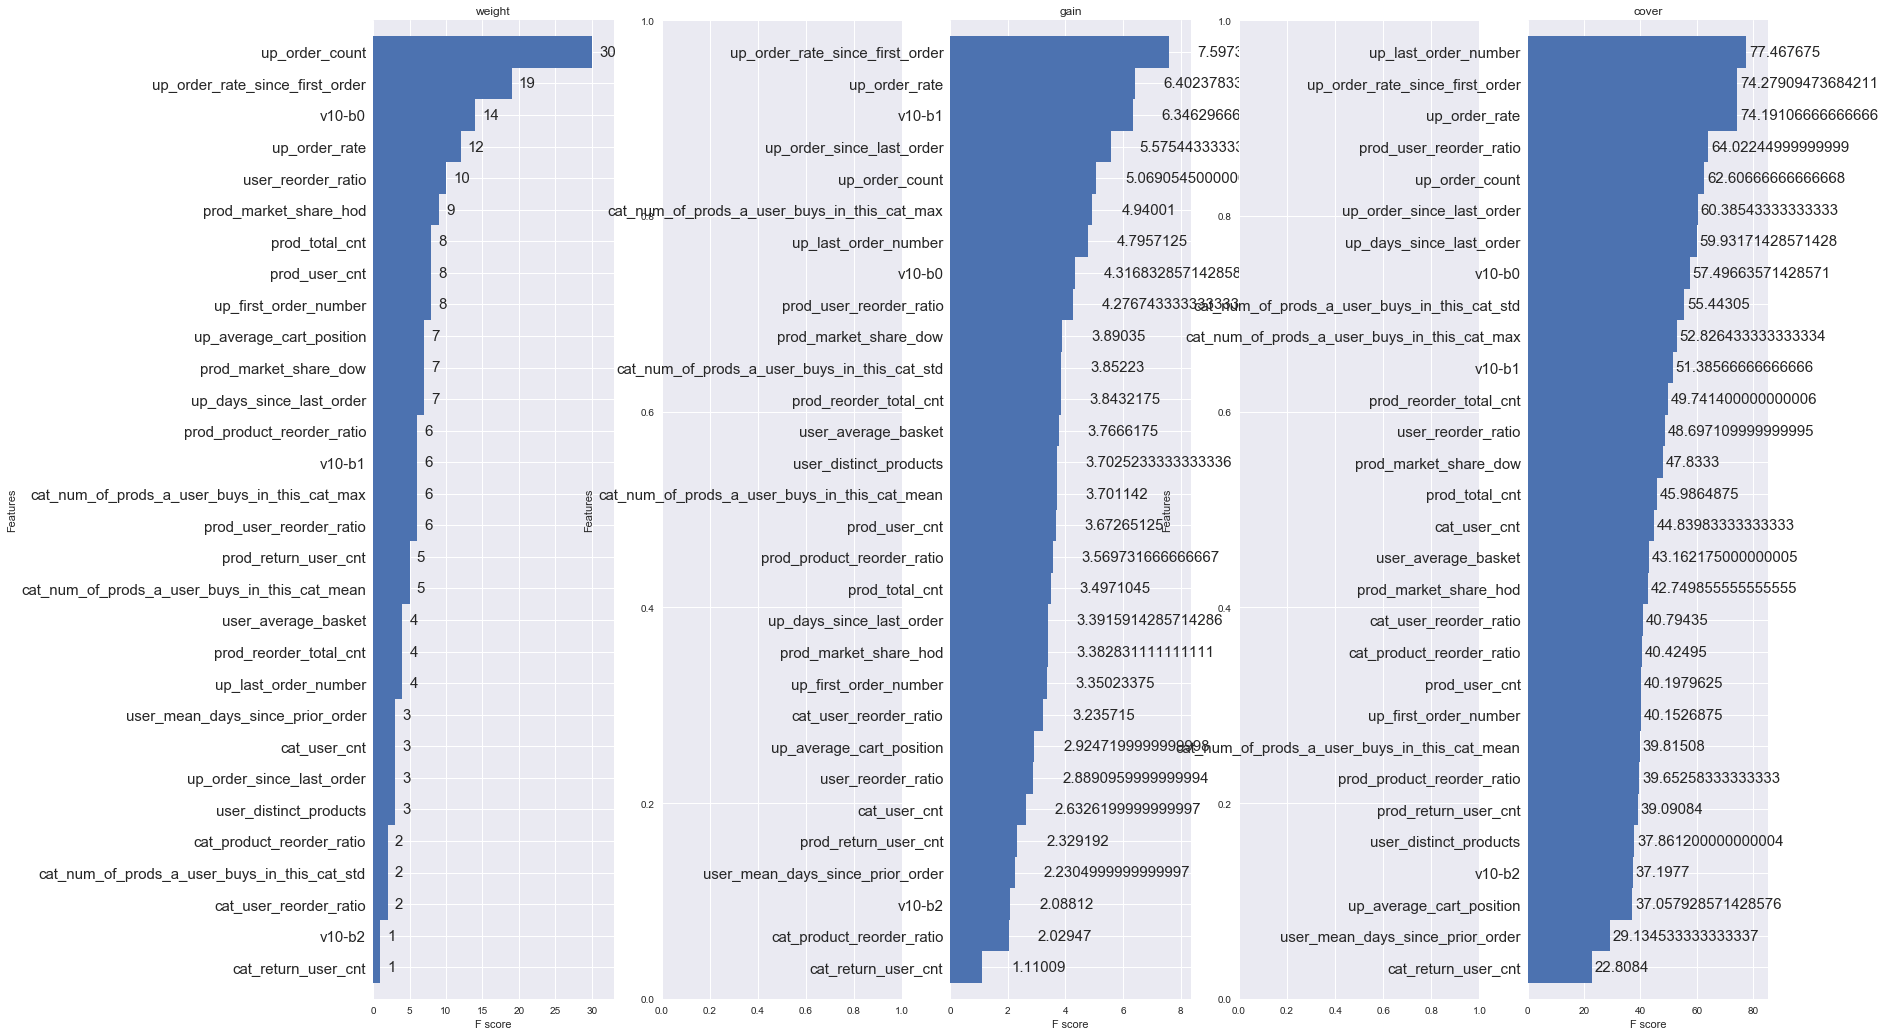

In [57]:
boosting_rounds=100
stopping_rounds = 10

X_train, X_val, y_train, y_val = train_test_split(
    train_df.drop(['eval_set', 'product_id', 'order_id', 'reordered'], axis=1),
    train_df.reordered,
    test_size=0.2, random_state=1019)

X_train.sort_index(axis=1, inplace=True)
X_val.sort_index(axis=1, inplace=True)

dtrain = xgboost.DMatrix(X_train, y_train)
dval = xgboost.DMatrix(X_val, y_val)

gc.collect()
print(dtrain.num_row(), dtrain.num_col())
print(dval.num_row(), dval.num_col())

bst = train(
    xgb_params, dtrain, num_boost_round=boosting_rounds,
    evals=[(dtrain, 'train'), (dval, 'val')],
    callbacks=[
            xgboost.callback.early_stop(stopping_rounds=stopping_rounds)
    ])

_, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,18))
measures = ['weight', 'gain', 'cover']
for i in range(3):
    plot_importance(bst, height=1, ax=axes[2*i], importance_type=measures[i], title=measures[i])
plt.show()

test.sort_index(axis=1, inplace=True)

dtest = xgboost.DMatrix(test.drop(['eval_set', 'order_id', 'reordered', 'product_id'], axis=1))
pred_t = bst.predict(dtest)
test_result = pd.DataFrame({'order_id':test.order_id,'product_id':test.product_id, 'reordered':pred_t})
test_result.to_csv(os.path.join(root, 'stacking', 'test_prediction.{}.csv'.format(name)), index=False)